# 2. Source Detection and Aperture Photometry for Cropped Region 1

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# list of filters and their names
filters = ['jwst_nircam_f115w', 'jwst_nircam_f150w', 'jwst_nircam_f200w', 'jwst_nircam_f277w',
           'jwst_nircam_f356w', 'jwst_nircam_f444w']

# number of filters
nbands = len(filters)

# Wavelength of the filters
photo_wave = [11540.0, 15010.0, 19890.0, 27620.0, 35680.0, 44080.0]

# Names of science images
sci_img = ['psfmatch_crop1_ceers5_f115w_sci.fits.gz', 'psfmatch_crop1_ceers5_f150w_sci.fits.gz', 
           'psfmatch_crop1_ceers5_f200w_sci.fits.gz', 'psfmatch_crop1_ceers5_f277w_sci.fits.gz', 
           'psfmatch_crop1_ceers5_f356w_sci.fits.gz', 'crop1_ceers5_f444w_sci.fits.gz']

# Names of variance images
var_img = ['psfmatch_crop1_var_ceers5_f115w_err.fits.gz', 'psfmatch_crop1_var_ceers5_f150w_err.fits.gz', 
           'psfmatch_crop1_var_ceers5_f200w_err.fits.gz', 'psfmatch_crop1_var_ceers5_f277w_err.fits.gz', 
           'psfmatch_crop1_var_ceers5_f356w_err.fits.gz', 'crop1_var_ceers5_f444w_err.fits.gz']

# pixel scale of the images
pixsize = 0.03

## 2.1. Source Detection and Extraction

We will use SEP for detecting sources and get the segmentation maps of them. For this example, let's base our detection on F150W band.

In [3]:
import sep

# get data image
hdu = fits.open('psfmatch_crop1_ceers5_f150w_sci.fits.gz')
data_sci = hdu[0].data
hdu.close()

data_sci = data_sci.byteswap(inplace=True).newbyteorder()

# get variance image
hdu = fits.open('psfmatch_crop1_ceers5_f150w_sci.fits.gz')
data_var = hdu[0].data
hdu.close()

data_var = data_var.byteswap(inplace=True).newbyteorder()
data_err = np.sqrt(data_var)

objects, segmap = sep.extract(data_sci, thresh=0.5, err=data_err, minarea=5, 
                      deblend_nthresh=32, deblend_cont=0.005, segmentation_map=True)

In [4]:
# Number of detected objects
nobj = len(objects)
print (nobj)

183


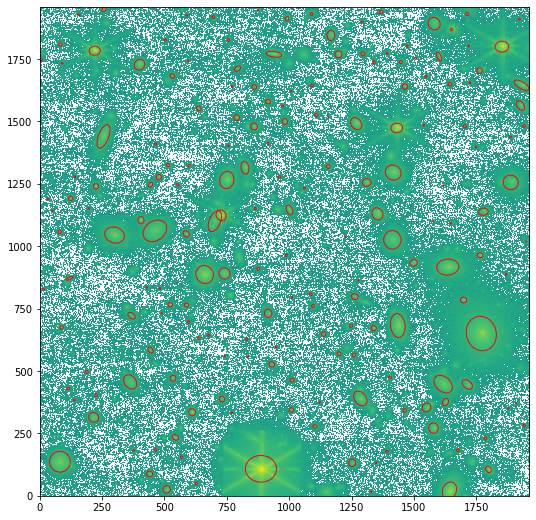

In [5]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots(figsize=(9,9))
im = ax.imshow(np.log10(data_sci), origin='lower')

# plot an ellipse for each object
for i in range(nobj):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i]*180.0/np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)


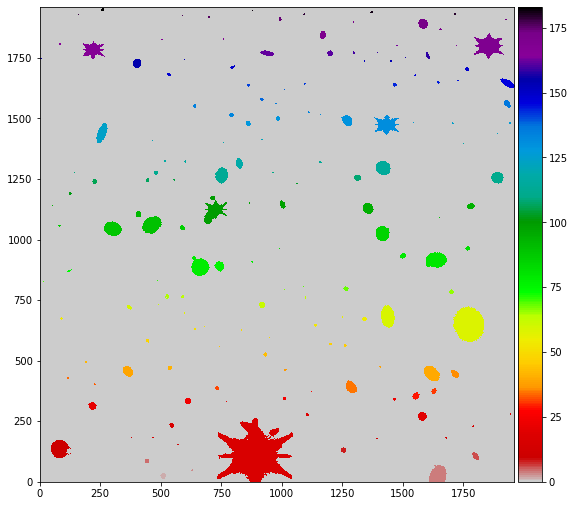

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(9,9))
f1 = plt.subplot()

im = plt.imshow(segmap, origin='lower', cmap='nipy_spectral_r')
divider = make_axes_locatable(f1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

In [7]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

## 2.2. Aperture Photometry

For this tutorial, we will compute aperture photometry based on circular aperture with a radius of 20 pixels or 0.6 arcsec.

In [8]:
# circular aperture radius
aper_radius = 20.0                     # in pixel (corresponds to 0.6 arcsec)

flux0 = np.zeros((nbands,nobj))
fluxerr0 = np.zeros((nbands,nobj))
flag0 = np.zeros((nbands,nobj))
for bb in range(0,nbands):
    hdu = fits.open(sci_img[bb])
    data_sci = hdu[0].data
    hdu.close()
    
    data_sci = data_sci.byteswap(inplace=True).newbyteorder()
    
    hdu = fits.open(var_img[bb])
    data_var = hdu[0].data
    hdu.close()
    
    data_var = data_var.byteswap(inplace=True).newbyteorder()
    data_err = np.sqrt(data_var)
    
    flux0[bb], fluxerr0[bb], flag0[bb] = sep.sum_circle(data_sci, objects['x'], objects['y'],
                                                 aper_radius, err=data_err, gain=1.0)
    
    # change nan or inf
    idx_ch = np.where(np.isnan(flux0[bb])==True)
    flux0[bb][idx_ch[0]] = -99.0
    
    idx_ch = np.where(np.isnan(fluxerr0[bb])==True)
    fluxerr0[bb][idx_ch[0]] = -99.0
  

In [9]:
# transpose from (band-id, obj-id) to (obj-id, band-id)
flux = np.transpose(flux0, axes=(1,0))
fluxerr = np.transpose(fluxerr0, axes=(1,0))
flag = np.transpose(flag0, axes=(1,0))

In [10]:
from astropy.table import QTable

fname = ['f115w', 'f150w', 'f200w', 'f277w', 'f356w', 'f444w']

idx = np.arange(nobj)
data_table = []
names = []
data_table.append(idx)
names.append('ID')
data_table.append(objects['x'])
names.append('x')
data_table.append(objects['y'])
names.append('y')
for bb in range(0,nbands):
    data_table.append(flux0[bb])
    names.append('f_%s' % fname[bb])
    data_table.append(fluxerr0[bb])
    names.append('fe_%s' % fname[bb])
    
names = tuple(names)

t = QTable(data_table, names=names, meta={'name': 'catalog'})

In [11]:
t

ID,x,y,f_f115w,fe_f115w,f_f150w,fe_f150w,f_f200w,fe_f200w,f_f277w,fe_f277w,f_f356w,fe_f356w,f_f444w,fe_f444w
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,1329.3818489747587,16.10249849942546,2.3091924285343817,1.5439303185138853,4.4581297232821635,2.138591420494131,4.253444394033514,2.080894820720312,4.0478069192835395,2.015158469097716,3.344019168751684,1.8306941856885126,3.0562850679254203,1.7568303848555664
1,508.9720740400283,25.32826256811101,25.281519643217617,5.036579282899676,53.50963936568238,7.324949707214823,65.37389715405179,8.091950649489636,81.7739717679843,9.043986581239324,94.67521488491447,9.730732496456223,99.27213629184284,9.965480527607545
2,627.3529655730877,48.02990643951057,3.869187725331103,1.9880941613227703,7.574365823582333,2.774862117018942,8.376744789467281,2.9088729445306254,9.201628308268239,3.0355333748294977,9.141036147803142,3.024618104322997,8.74916178006622,2.9626882186133825
3,1642.4383581561751,20.739073017790695,1019.1806788098804,31.930628689268563,1601.150554323196,40.0298804781299,2011.3994016104932,44.86097525761452,2370.3888563221685,48.692021890250636,1645.536893289089,40.566937925888375,1296.1463600513337,36.005127665746116
4,441.0360578410841,87.03158064180722,19.74989666605925,4.453495586356696,38.376996194875375,6.205911529607876,48.76302568424362,6.990105040246437,62.55379911551019,7.910216716732838,79.46440089496785,8.91489926017411,86.23977500916696,9.288527117987565
5,1798.6623474447197,105.4555320241804,178.10688941993752,13.350866179963873,240.83867162991322,-99.0,322.7695834609122,17.973033557286406,397.3360933469421,-99.0,484.1089225785111,22.003528887058497,437.9440338549344,20.929496886212593
6,1349.1810871102737,131.5417365890904,5.4744109616685295,2.3565729084308384,5.909011994399297,2.455479193909524,6.234090112166669,2.5128445919428097,5.2433353809823,2.2929555956787464,5.199360086048688,2.2819874716412207,4.964295296079919,2.2355903452778194
7,1252.7165719302686,131.65825171344426,33.26858708615424,5.775368986276718,40.52726562758909,6.376901473868254,71.40056418038904,8.456233358825497,86.42411768555641,9.297685947087103,106.86854448974134,10.338409970960194,128.36136856738477,11.331683460205348
8,569.3794042130448,153.90314501374843,6.475526783246788,2.560580676390829,8.193545385733483,2.8836006652114325,9.11148786175003,3.032091338918053,8.06763418224969,2.8426114682522328,7.967009009758722,2.8238805683964636,7.820282718139124,2.801830360447671


JWST data units: MJy/sr

Mega Janskys (MJy); mag_AB = 8.9 - 2.5 log10(flux_Jy) = 31.4 - 2.5 log10(flux_nJy)

steradian (sr) = 4.255e+10 arcsec^2

## 2.3. Convert surface brightness from MJy/sr to micro-Jy and erg/s/cm^2/A

In [12]:
arcsec2_per_sr = 4.25e+10
#sr_per_pix = sr_per_arcsec2*arcsec2_per_pix
sr_per_pix = pixsize*pixsize/arcsec2_per_sr

## convert to uJy
flux_uJy = flux*sr_per_pix*1e+12
fluxerr_uJy = fluxerr*sr_per_pix*1e+12

## convert to erg/s/cm^2
flux_ergscmA = flux_uJy*1e-6*1.0e-23*2.998e+18/photo_wave/photo_wave
fluxerr_ergscmA = fluxerr_uJy*1e-6*1.0e-23*2.998e+18/photo_wave/photo_wave

## 2.4. Calculate AB magnitudes

In [14]:
# AB magnitude
mag_AB = 8.9 - 2.5*np.log10(flux_uJy*1e-6)

# AB magnitude uncertainty
mag_AB_err = 2.5*np.log10(1 + fluxerr/flux)

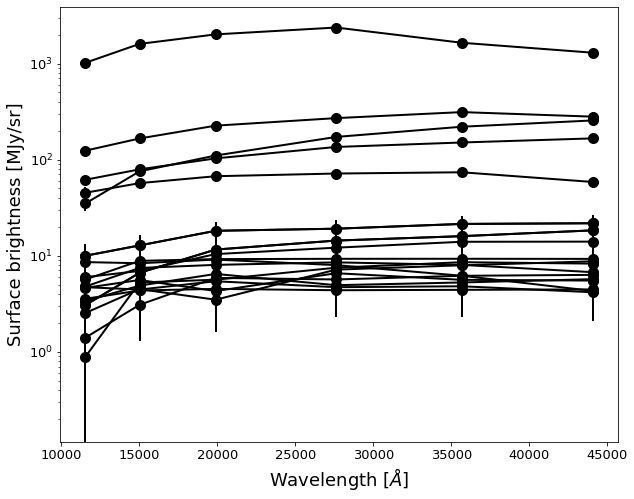

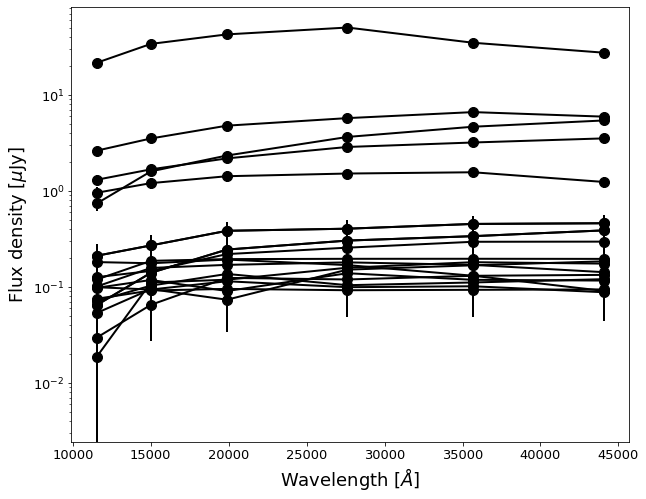

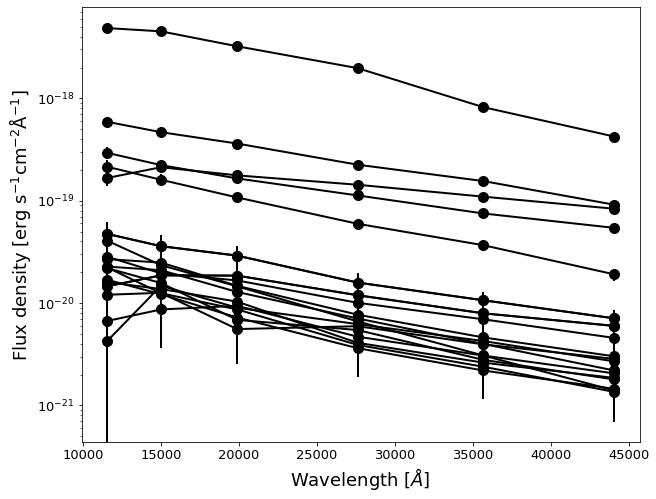

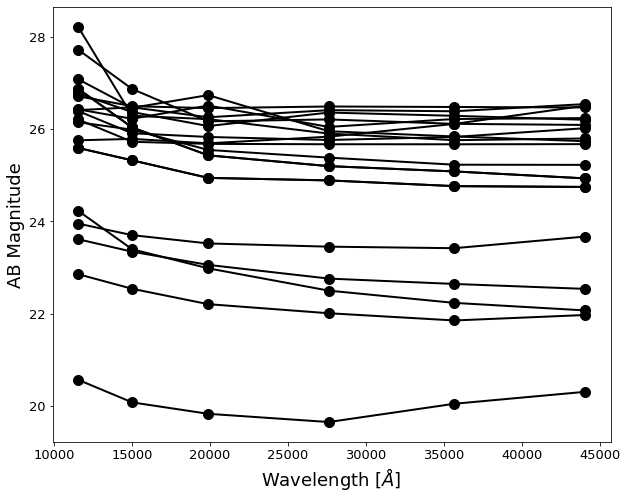

In [15]:
# choose 20 random objects
idx = np.random.randint(0,nobj-1,20)


# plot SED in surface brightness unit
fig1 = plt.figure(figsize=(10,8))
f1 = plt.subplot()
f1.set_yscale('log')
plt.xlabel(r"Wavelength [$\AA$]", fontsize=18)
plt.ylabel(r"Surface brightness [MJy/sr]", fontsize=18)
plt.setp(f1.get_yticklabels(), fontsize=13)
plt.setp(f1.get_xticklabels(), fontsize=13)
#plt.ylim(1e-1,1e+3)

for ii in range(0,20):
    plt.errorbar(photo_wave, flux[idx[ii]], yerr=fluxerr[idx[ii]], 
                     fmt='-o', markersize=10, lw=2, color='black')
plt.show()


# plot SED in flux density (micro Jy) unit
fig1 = plt.figure(figsize=(10,8))
f1 = plt.subplot()
f1.set_yscale('log')
plt.xlabel(r"Wavelength [$\AA$]", fontsize=18)
plt.ylabel(r"Flux density [$\mu$Jy]", fontsize=18)
plt.setp(f1.get_yticklabels(), fontsize=13)
plt.setp(f1.get_xticklabels(), fontsize=13)
#plt.ylim(1e-1,1e+3)

for ii in range(0,20):
    plt.errorbar(photo_wave, flux_uJy[idx[ii]], yerr=fluxerr_uJy[idx[ii]], 
                     fmt='-o', markersize=10, lw=2, color='black')
plt.show()


# plot SED in flux density (erg/s/cm^2/A) unit
fig1 = plt.figure(figsize=(10,8))
f1 = plt.subplot()
f1.set_yscale('log')
plt.xlabel(r"Wavelength [$\AA$]", fontsize=18)
plt.ylabel(r"Flux density [erg $\rm{ s}^{-1}\rm{cm}^{-2}\AA^{-1}$]", fontsize=18)
plt.setp(f1.get_yticklabels(), fontsize=13)
plt.setp(f1.get_xticklabels(), fontsize=13)
#plt.ylim(1e-1,1e+3)

for ii in range(0,20):
    plt.errorbar(photo_wave, flux_ergscmA[idx[ii]], yerr=fluxerr_ergscmA[idx[ii]], 
                     fmt='-o', markersize=10, lw=2, color='black')
plt.show()


# plot SED in AB magnitude
fig1 = plt.figure(figsize=(10,8))
f1 = plt.subplot()
plt.xlabel(r"Wavelength [$\AA$]", fontsize=18)
plt.ylabel(r"AB Magnitude", fontsize=18)
plt.setp(f1.get_yticklabels(), fontsize=13)
plt.setp(f1.get_xticklabels(), fontsize=13)
#plt.ylim(1e-1,1e+3)

for ii in range(0,20):
    plt.errorbar(photo_wave, mag_AB[idx[ii]], yerr=fluxerr_ergscmA[idx[ii]], 
                     fmt='-o', markersize=10, lw=2, color='black')
plt.show()

## 2.5. Store the SEDs into a text file

In [16]:
file_out = open('ceers_obj_crop1.cat', 'w')
file_out.write('#id f_f115w e_f115w f_f150w e_f150w f_f200w e_f200w f_f277w e_f277w f_f356w e_f356w f_f444w e_f444w z_spec\n')
file_out.write('#id F364 E364 F365 E365 F366 E366 F375 E375 F376 E376 F377 E377 z_spec\n')

for ii in range(0,nobj):
    
    file_out.write("%d  " % (ii+1))
    for bb in range(0,nbands):
        file_out.write("%e  %e  " % (flux_uJy[ii][bb],fluxerr_uJy[ii][bb]))
    file_out.write("-1.000\n")

file_out.close()